In [1]:
import sys
sys.path.append("../../")
import cv2

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchsummary import summary
import albumentations as A
from torch_lr_finder import LRFinder

from dataloader import get_CIFAR10dataset, CIFAR10_dataset, get_transforms, get_dataloader, get_CIFAR10_musigma
from models.resnet import ResNet18, ResNet34
from train import train_epoch, test_epoch
from utils import show_samples, plot_loss, plot_acc, get_misclassified, get_denormalized_imgs, get_gradcam_img, show_gradcam_plots, show_misclassified_imgs

from matplotlib import pyplot as plt
import numpy as np

C:\Users\Sachin\anaconda3\envs\cvaiac2023\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Set Global Config

In [3]:
SEED = 1

# CUDA?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA Available?", device)

# For reproducibility
torch.manual_seed(SEED)

if device=='cuda':
    torch.cuda.manual_seed(SEED)

CUDA Available? cuda


# Get the data 

In [4]:
train_data = get_CIFAR10dataset(root="../../data", train_flag=True, download_flag=True)
test_data = get_CIFAR10dataset(root="../../data", train_flag=False, download_flag=True)

Files already downloaded and verified
Files already downloaded and verified


# Create CIFAR10- Dataset + DataLoader with transforms

In [5]:
bs = 512
train_tfms_list = [
                  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=get_CIFAR10_musigma()[0], p=1.0), #border_mode=0 needs fill value
                  A.RandomCrop(height=32, width=32, p=1.0),
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(
                    max_holes=1,
                    max_height=16,
                    max_width=16,
                    min_holes=1,
                    min_height=16,
                    min_width=16,
                    fill_value=get_CIFAR10_musigma()[0],
                    mask_fill_value=None,
                    p=0.5,
                    )
                  ]


train_tfms = get_transforms(basic=False, tfms_list=train_tfms_list)
test_tfms = get_transforms(basic=True, tfms_list=None)

train_ds = CIFAR10_dataset(data=train_data.data, targets=train_data.targets, transforms=train_tfms)
test_ds = CIFAR10_dataset(data=test_data.data, targets=test_data.targets, transforms=test_tfms)

train_dl = get_dataloader(train_ds, bs_cuda=bs, bs_cpu=64, device=device)
test_dl = get_dataloader(test_ds, bs_cuda=bs, bs_cpu=64, device=device)

# visualize some samples from training set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


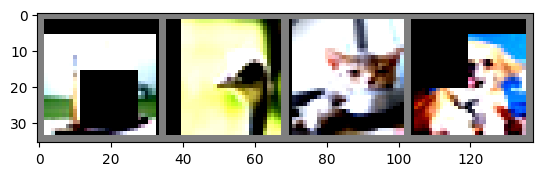

ship  bird  cat   dog  


In [6]:
# get some random training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
show_samples(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Build the Network

In [7]:
model = ResNet18().to(device)
# sanity check
xx = torch.rand(1,3,32,32).to(device)
yy = model(xx)
yy.shape

torch.Size([1, 10])

In [8]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

# LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-04


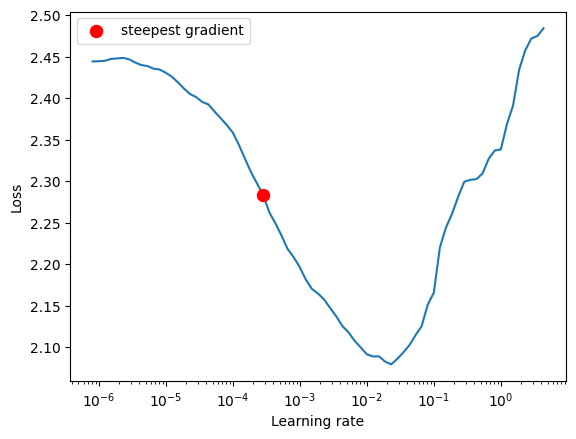

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

**Summary**
- use lower lr = 1e-4 and upper lr = 1e-3 for once cycle scheduling

# Train the model

In [11]:
EPOCHS = 20

In [12]:
criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(train_dl), pct_start=0.2, div_factor=10)

train_stats = {}
test_stats = {}
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model, device, train_dl, optimizer, criterion, epoch, train_stats)
    scheduler.step()
    test_epoch(model, device, test_dl, criterion_test, test_stats)


Loss=2.50154447555542 Batch_id=0 Accuracy=10.55:   0%|                                          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4328117370605469 Batch_id=97 Accuracy=37.87: 100%|██████████████████████████████| 98/98 [00:18<00:00,  5.38it/s]
Loss=1.4231321811676025 Batch_id=0 Accuracy=49.61:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4535, Accuracy: 4703/10000 (47.03%)

EPOCH: 1


Loss=1.2810288667678833 Batch_id=97 Accuracy=51.15: 100%|██████████████████████████████| 98/98 [00:18<00:00,  5.31it/s]
Loss=1.2255460023880005 Batch_id=0 Accuracy=54.88:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1810, Accuracy: 5857/10000 (58.57%)

EPOCH: 2


Loss=1.146443486213684 Batch_id=97 Accuracy=57.67: 100%|███████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]
Loss=1.0851024389266968 Batch_id=0 Accuracy=59.18:   0%|                                        | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0578, Accuracy: 6269/10000 (62.69%)

EPOCH: 3


Loss=1.031392216682434 Batch_id=97 Accuracy=62.46: 100%|███████████████████████████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9428, Accuracy: 6710/10000 (67.10%)

EPOCH: 4


Loss=0.9066674113273621 Batch_id=97 Accuracy=65.84: 100%|██████████████████████████████| 98/98 [00:20<00:00,  4.82it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9171, Accuracy: 6781/10000 (67.81%)

EPOCH: 5


Loss=0.8204814195632935 Batch_id=97 Accuracy=68.36: 100%|██████████████████████████████| 98/98 [00:20<00:00,  4.76it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7656, Accuracy: 7322/10000 (73.22%)

EPOCH: 6


Loss=0.796021580696106 Batch_id=97 Accuracy=70.74: 100%|███████████████████████████████| 98/98 [00:22<00:00,  4.33it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8009, Accuracy: 7192/10000 (71.92%)

EPOCH: 7


Loss=0.7638875842094421 Batch_id=97 Accuracy=72.83: 100%|██████████████████████████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7102, Accuracy: 7535/10000 (75.35%)

EPOCH: 8


Loss=0.6469628214836121 Batch_id=97 Accuracy=74.67: 100%|██████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6418, Accuracy: 7799/10000 (77.99%)

EPOCH: 9


Loss=0.6729413270950317 Batch_id=97 Accuracy=75.69: 100%|██████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6293, Accuracy: 7846/10000 (78.46%)

EPOCH: 10


Loss=0.6460781097412109 Batch_id=97 Accuracy=77.14: 100%|██████████████████████████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5908, Accuracy: 8013/10000 (80.13%)

EPOCH: 11


Loss=0.6757383346557617 Batch_id=97 Accuracy=77.98: 100%|██████████████████████████████| 98/98 [00:32<00:00,  3.00it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5907, Accuracy: 8017/10000 (80.17%)

EPOCH: 12


Loss=0.5930835604667664 Batch_id=97 Accuracy=78.94: 100%|██████████████████████████████| 98/98 [00:32<00:00,  3.00it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6161, Accuracy: 7908/10000 (79.08%)

EPOCH: 13


Loss=0.6085094809532166 Batch_id=97 Accuracy=79.88: 100%|██████████████████████████████| 98/98 [00:32<00:00,  2.98it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5757, Accuracy: 8062/10000 (80.62%)

EPOCH: 14


Loss=0.5066645741462708 Batch_id=97 Accuracy=80.71: 100%|██████████████████████████████| 98/98 [00:35<00:00,  2.76it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4924, Accuracy: 8299/10000 (82.99%)

EPOCH: 15


Loss=0.4659685492515564 Batch_id=97 Accuracy=81.22: 100%|██████████████████████████████| 98/98 [00:35<00:00,  2.80it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6012, Accuracy: 8016/10000 (80.16%)

EPOCH: 16


Loss=0.5275770425796509 Batch_id=97 Accuracy=82.03: 100%|██████████████████████████████| 98/98 [00:37<00:00,  2.58it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5120, Accuracy: 8276/10000 (82.76%)

EPOCH: 17


Loss=0.5449625849723816 Batch_id=97 Accuracy=82.40: 100%|██████████████████████████████| 98/98 [00:37<00:00,  2.59it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4867, Accuracy: 8383/10000 (83.83%)

EPOCH: 18


Loss=0.5186169743537903 Batch_id=97 Accuracy=82.92: 100%|██████████████████████████████| 98/98 [00:42<00:00,  2.29it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5287, Accuracy: 8307/10000 (83.07%)

EPOCH: 19


Loss=0.5247153639793396 Batch_id=97 Accuracy=83.37: 100%|██████████████████████████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.5105, Accuracy: 8349/10000 (83.49%)



**Summary**
- We used Once cycle LR scheduling
- Our constraints are
  - Network architecture: ResNet18
  - Max Epochs = 20
  - high lr = 1e-3
  - low lr = 1e-4
  - Max @ epoch = 4
- We achieved accuracy of ~84% in 20 epcohs w/o overfitting

# Train and Test loss/Accuracy

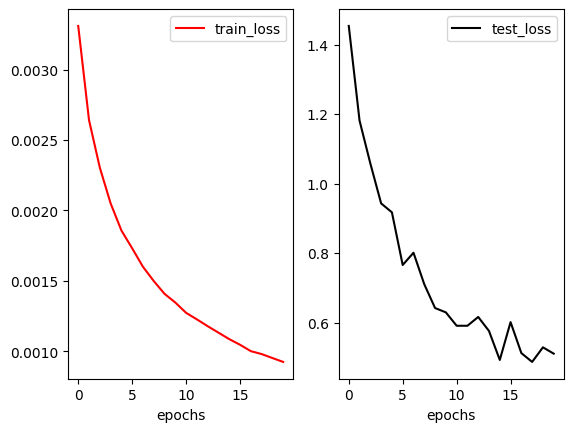

In [13]:
plot_loss(train_stats, test_stats)

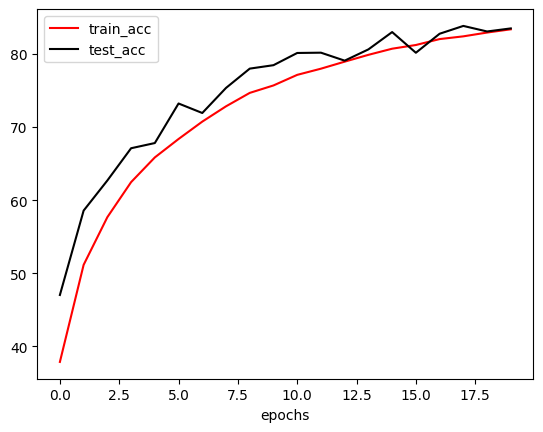

In [14]:
plot_acc(train_stats, test_stats)

# Mis-classified images

In [15]:
misclassified = {}
get_misclassified(model, device, test_dl, misclassified, num_samples=10)

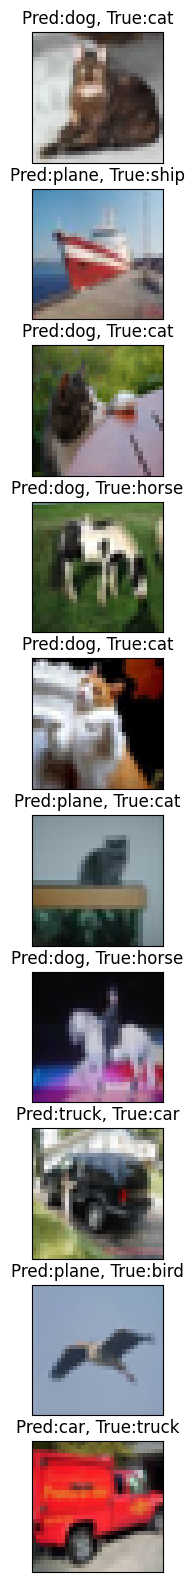

In [24]:
show_misclassified_imgs(misclassified, classes, nmax=10)

# Grad-CAM on mis-classified images

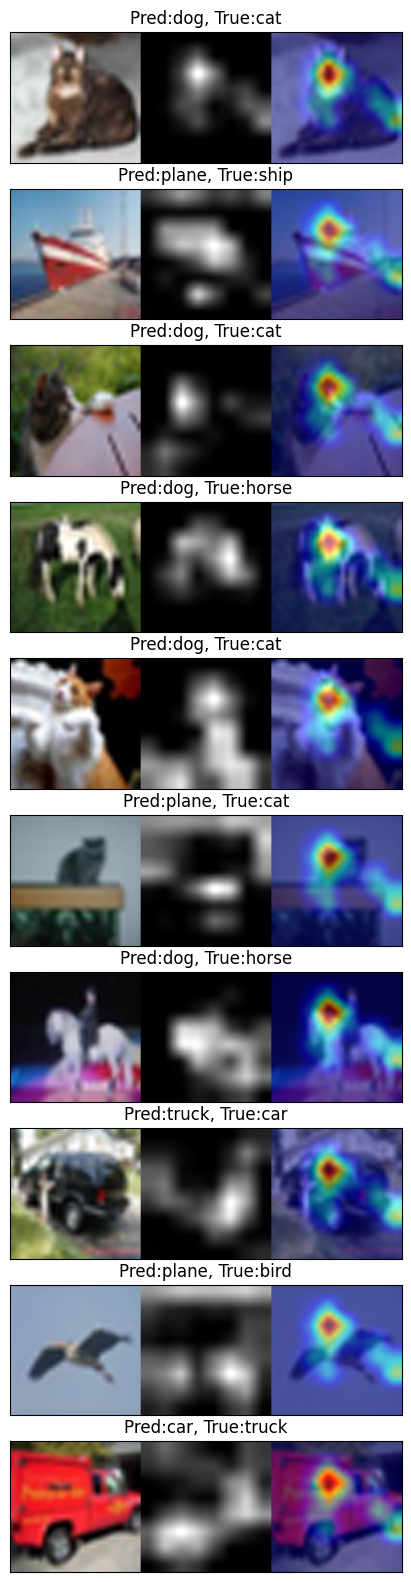

In [20]:
input_tensor = misclassified['data']
original_imgs = get_denormalized_imgs(input_tensor)
wrong_preds = misclassified['pred']
correct_labels = misclassified['target']
target_layers = [model.layer3[-1]]
grayscale_cams, cam_image = get_gradcam_img(model, target_layers, input_tensor, original_imgs, wrong_preds)
show_gradcam_plots(grayscale_cams, cam_image, original_imgs, classes, \
                       wrong_preds, correct_labels, resize=(1024,1024), figsize=(20,20))